#

# STOCHASTIC PROCESS

## 0 - Setup e import dei tools e funzioni

In [3]:
import os, sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Imposto la root del progetto a partire dalla posizione di questo file
PROJECT_ROOT = Path.cwd().parent
SRC_DIR = PROJECT_ROOT / "src"
DATA_RESULTS = PROJECT_ROOT / "data" / "results"
DATA_RESULTS.mkdir(parents=True, exist_ok=True)

# Aggiungo la cartella src al path per poter importare i moduli personalizzati
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

# Importo i moduli personalizzati
from brownian import simulate_brownian_with_drift, simulate_standard_brownian_motion
from gbm import simulate_gbm
from utils_plot import plot_paths

## 1 - Definisco i parametri

In [1]:
# parametri base
T = 1.0 # orizzonte temporale
N = 10000 # numero di step
M = 50000  # numero di traiettorie
seed = 42  # seme per la riproducibilità

# parametri per il moto browniano con drift
mu = 0.3  # drift
sigma = 0.2 # volatilità
S0 = 100  # prezzo iniziale

# Versione più leggera per il plot
M_plot = 200  # numero di traiettorie da plottare

# SBM - simulazione, plot e test di distribuzione 

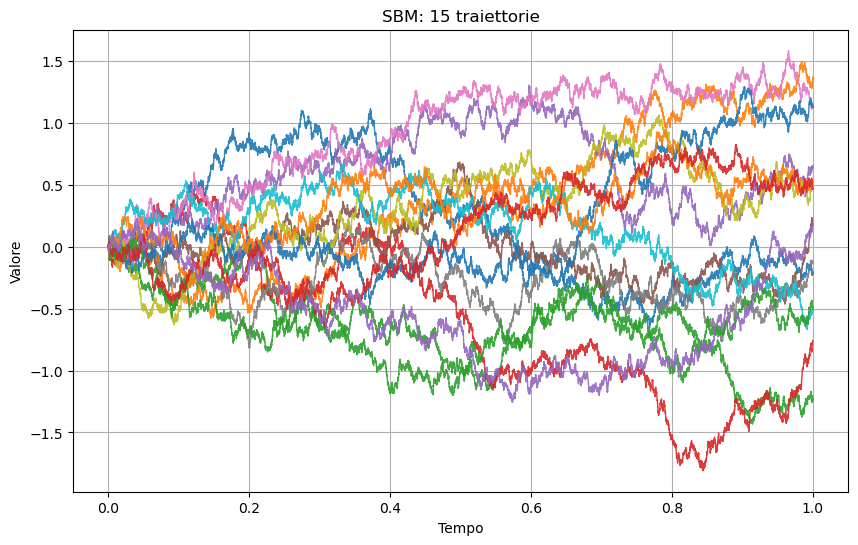

SBM: E[W(T)] = -0.0056, 
 Var[W(T)] = 1.0031 (theoretical: 0, T=1.0)


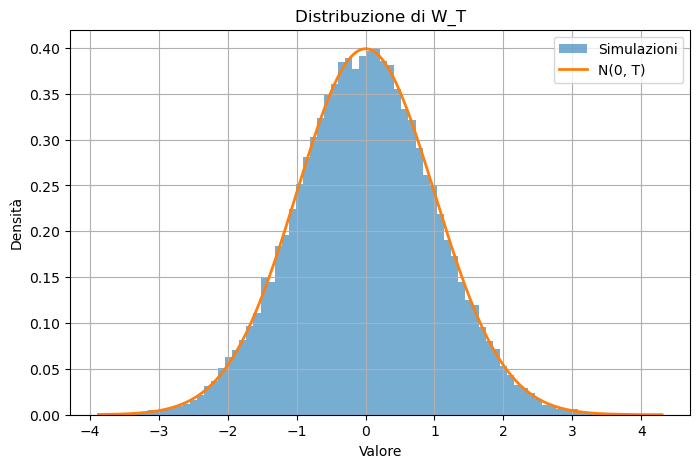

In [4]:
# simulo il moto browniano standard per il plot
t, W = simulate_standard_brownian_motion(T, N, M, seed)
plot_paths(t, W, title="SBM: 15 traiettorie", n_paths=15, save_path=DATA_RESULTS / "sbm_15_paths.png")

# simulo il moto browniano standard per il test statistico
t, W = simulate_standard_brownian_motion(T, N, M, seed)
W_T = W[:, -1]  # valori finali del moto browniano standard
mean_W_T = np.mean(W_T)
var_W_T = np.var(W_T)

print(f"SBM: E[W(T)] = {mean_W_T:.4f}, \n Var[W(T)] = {var_W_T:.4f} (theoretical: 0, T={T})")

# Istogramma vs pdf teorica
plt.figure(figsize=(8, 5))
plt.hist(W_T, bins=80, density=True, alpha=0.6, label="Simulazioni")
x = np.linspace(W_T.min(), W_T.max(), 400)
pdf = (1 / np.sqrt(2 * np.pi * T)) * np.exp(-(x**2) / (2 * T))
plt.plot(x, pdf, lw=2, label="N(0, T)")
plt.title("Distribuzione di W_T")
plt.xlabel("Valore"); plt.ylabel("Densità")
plt.legend(); plt.grid(True)
plt.savefig(DATA_RESULTS / "sbm_WT_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

# Browniano con drift

Browniano con drift: E[X_T] ≈ 0.2989 (atteso 0.3000)
Browniano con drift: Var(X_T) ≈ 0.0401 (atteso 0.0400)


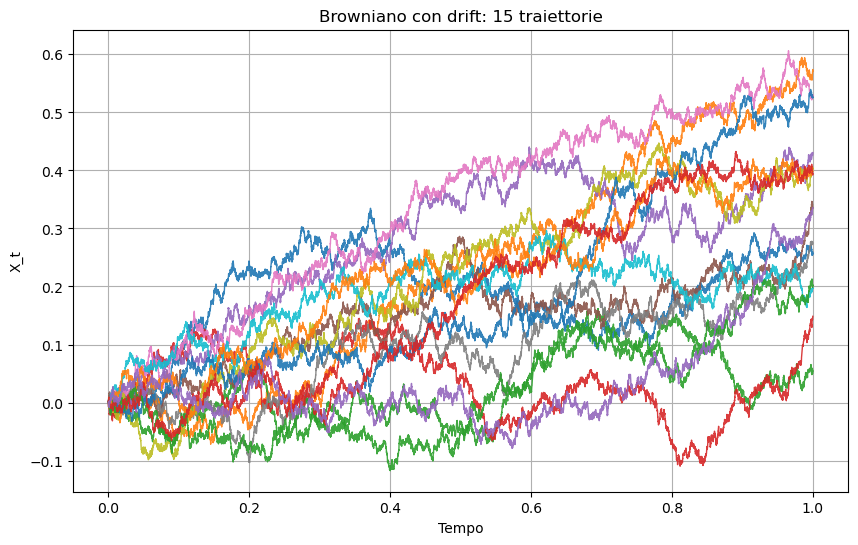

In [7]:
# Simulazione e test
t, X = simulate_brownian_with_drift(mu, sigma, T, N, M, seed)
X_T = X[:, -1]  # valori finali del moto browniano con drift

print(f"Browniano con drift: E[X_T] ≈ {X_T.mean():.4f} (atteso {mu*T:.4f})")
print(f"Browniano con drift: Var(X_T) ≈ {X_T.var():.4f} (atteso {(sigma**2)*T:.4f})")

# plot delle traiettorie
t, X_plot = simulate_brownian_with_drift(mu, sigma, T, N, M_plot, seed)
plot_paths(t, X_plot, title="Browniano con drift: 15 traiettorie", n_paths=15, save_path=DATA_RESULTS / "brownian_drift_15_paths.png", ylabel="X_t")

# GBM - simulazione, plot e test su log-prezzo

GBM: mean log(S_T/S0) ≈ 0.2789 (atteso 0.2800)
GBM: var  log(S_T/S0) ≈ 0.0401 (atteso 0.0400)


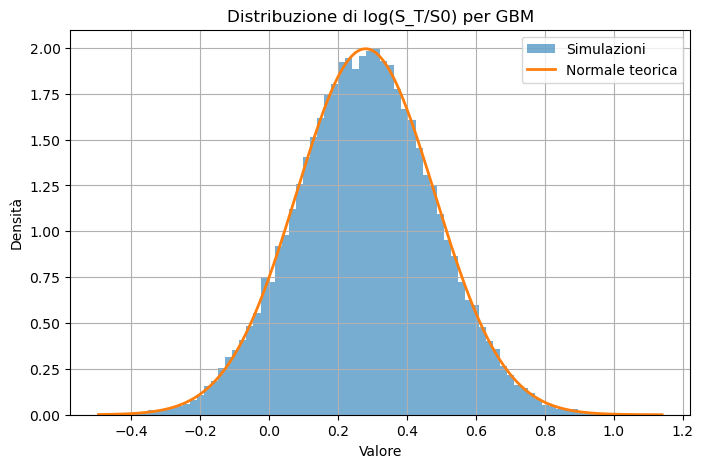

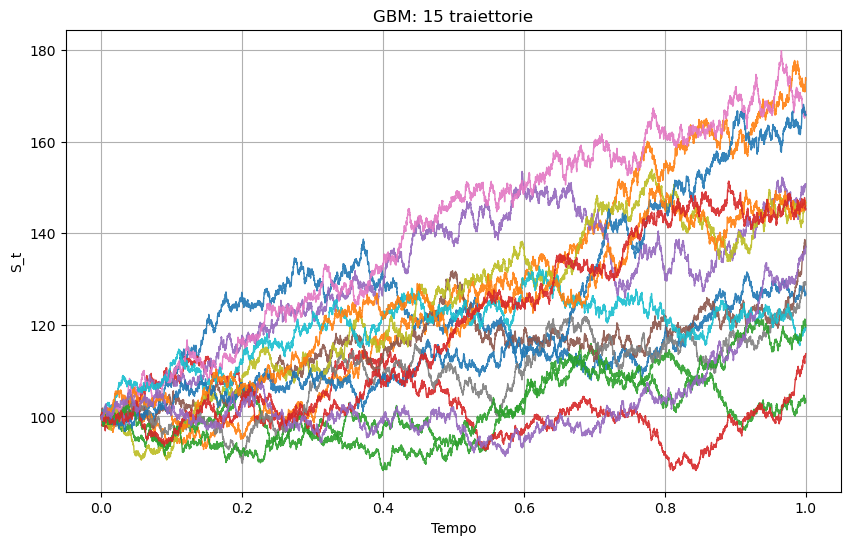

In [8]:
# Simulazione GBM
t, S = simulate_gbm(S0, mu, sigma, T, N, M, seed)
S_T = S[:, -1]  # valori finali del GBM
log_S_T = np.log(S_T / S0)  # log-returns

theorical_mean = (mu - 0.5 * sigma**2) * T # E[log(S_T/S0)]
theorical_var = sigma**2 * T     # Var(log(S_T/S0))

print(f"GBM: mean log(S_T/S0) ≈ {log_S_T.mean():.4f} (atteso {theorical_mean:.4f})")
print(f"GBM: var  log(S_T/S0) ≈ {log_S_T.var():.4f} (atteso {theorical_var:.4f})")

# Istogramma vs pdf teorica
plt.figure(figsize=(8,5))
plt.hist(log_S_T, bins=80, density=True, alpha=0.6, label="Simulazioni")
x = np.linspace(log_S_T.min(), log_S_T.max(), 400)
pdf = (1/np.sqrt(2*np.pi*theorical_var)) * np.exp(- (x-theorical_mean)**2 / (2*theorical_var))
plt.plot(x, pdf, lw=2, label="Normale teorica")
plt.title("Distribuzione di log(S_T/S0) per GBM")
plt.xlabel("Valore"); plt.ylabel("Densità")
plt.legend(); plt.grid(True)
plt.savefig(DATA_RESULTS / "gbm_log_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

# Plot path (pochi)
t, S_plot = simulate_gbm(S0, mu, sigma, T, N, 200, seed=seed)
plot_paths(t, S_plot, n_paths=15, title="GBM: 15 traiettorie", ylabel="S_t",
           save_path=DATA_RESULTS / "gbm_paths.png")

# Sensibilita' dei parametri

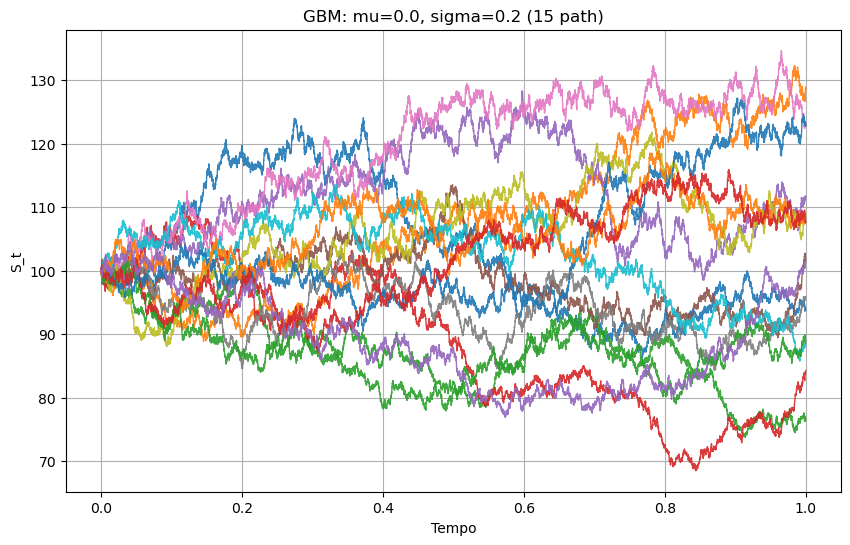

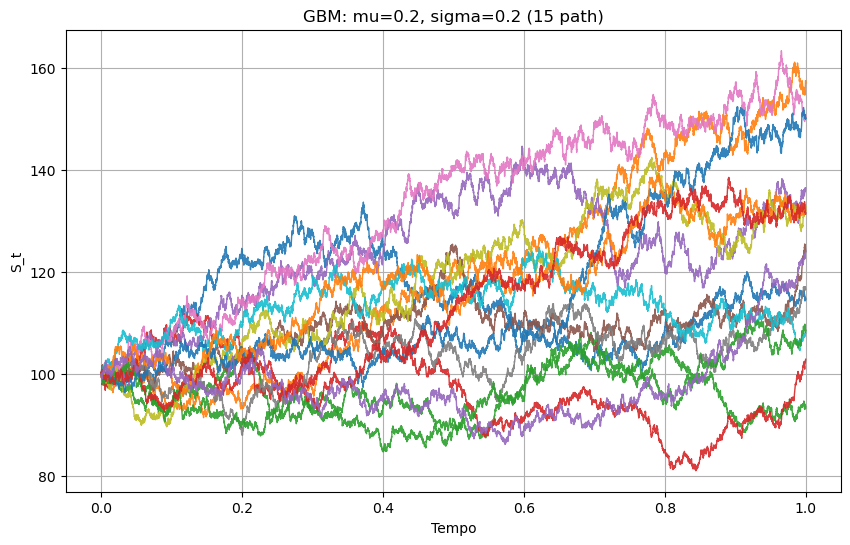

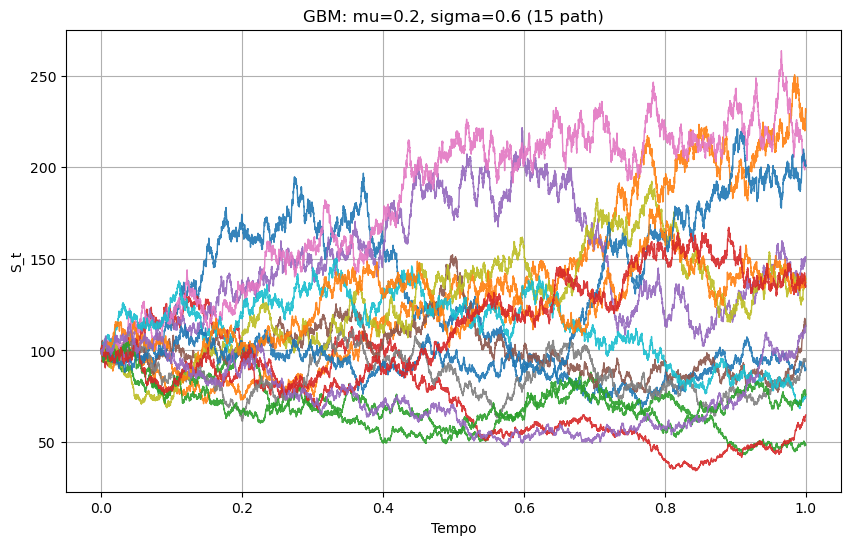

In [10]:
grid = [
    {"mu": 0.0, "sigma": 0.2},
    {"mu": 0.2, "sigma": 0.2},
    {"mu": 0.2, "sigma": 0.6},
]

for i, pars in enumerate(grid, 1):
    t, Sg = simulate_gbm(S0, pars["mu"], pars["sigma"], T, N, 200, seed=seed)
    title = f"GBM: mu={pars['mu']}, sigma={pars['sigma']} (15 path)"
    plot_paths(t, Sg, n_paths=15, title=title, ylabel="S_t",
               save_path=DATA_RESULTS / f"gbm_paths_sweep_{i}.png")


# Salvataggio degli ultimi dati accessibili

In [11]:
# Esempio: salvo l'ultimo vettore S_T e W_T per analisi successive
np.save(DATA_RESULTS / "W_T.npy", W_T)
np.save(DATA_RESULTS / "log_S_T_over_S0.npy", log_S_T)

# (Facoltativo) csv piccoli
np.savetxt(DATA_RESULTS / "W_T.csv", W_T, delimiter=",")
np.savetxt(DATA_RESULTS / "log_S_T_over_S0.csv", log_S_T, delimiter=",")
